In [ ]:
import torch.nn.functional as F
import torch.nn as nn
import torch
import numpy as np

import math
from pdb import set_trace as bp
import numpy as np
import os
import random
import pickle
import time
import torch
import math
import copy
import torch.utils.data as data
from copy import deepcopy
import time

import torch
import torch.utils.data as data
import torch.optim as optim
from google.colab import files
import random
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt



In [ ]:
work_dir="/content"
os.chdir(work_dir)

# Print the current working directory to verify the change
print("Current Working Directory:", os.getcwd())

Current Working Directory: /content


In [ ]:
uploaded=files.upload()
uploaded=files.upload()
uploaded=files.upload()

Saving Valid to Valid


Saving Train to Train


Saving Test to Test


In [ ]:
# from google.colab import drivea
# drive.mount('/content/drive')

functions

util

In [ ]:
import pickle
import torch
from torch.optim import Adam
from IPython.display import clear_output, display

def T_annealing(epoch, max_epoch, initial_T, end_T):
    new_T = initial_T * ((end_T / initial_T) ** (epoch / max_epoch))
    return new_T

def run_base(run_dict, model, file=""):
    optimizer = Adam(model.parameters(), lr=run_dict['lr'], weight_decay=run_dict['reg'])
    train_loader, test_dataset = run_dict['train_loader'], run_dict['test_dataset']
    gpu = run_dict['gpu']
    early_stop = 0.
    history = []

    # Begin training
    for epoch in range(run_dict['max_epoch'] + 1):
        train_loader.dataset.negative_sampling()
        epoch_loss = []

        for batch_user, batch_pos_item, batch_neg_item in train_loader:
            batch_user = batch_user.to(gpu)
            batch_pos_item = batch_pos_item.to(gpu)
            batch_neg_item = batch_neg_item.to(gpu)

            model.train()

            # Base Model
            output = model(batch_user, batch_pos_item, batch_neg_item)
            base_loss = model.get_loss(output)
            batch_loss = base_loss
            epoch_loss.append(batch_loss)

            # Backward and optimize
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        epoch_loss = float(torch.mean(torch.stack(epoch_loss)))

        # Evaluation
        if epoch % run_dict['eval_period'] == 0:
            model.eval()
            with torch.no_grad():
                eval_results = evaluate(model, gpu, train_loader, test_dataset)
                current_R50 = eval_results['test']['R50']

            history.append(current_R50)
            clear_output()
            display('Epoch [%d/%d], Recall@50: %.4f' % (epoch, run_dict['max_epoch'], current_R50))

    clear_output()
    print("Train Done!, Recall@50: %.4f" % (current_R50))

    if file:
        save_to_pickle(model, file)

    return history

def run_FTD(run_dict, model, file=None):
    optimizer = Adam(model.parameters(), lr=run_dict['lr'], weight_decay=run_dict['reg'])
    train_loader, test_dataset = run_dict['train_loader'], run_dict['test_dataset']
    gpu = run_dict['gpu']
    early_stop = 0.
    history = []

    # Begin training
    for epoch in range(run_dict['max_epoch'] + 1):
        train_loader.dataset.negative_sampling()
        epoch_loss = []

        for batch_user, batch_pos_item, batch_neg_item in train_loader:
            batch_user = batch_user.to(gpu)
            batch_pos_item = batch_pos_item.to(gpu)
            batch_neg_item = batch_neg_item.to(gpu)

            model.train()

            # Base Model
            output = model(batch_user, batch_pos_item, batch_neg_item)
            base_loss = model.get_loss(output)

            # Topology Distillation
            TD_loss = model.get_TD_loss(batch_user.unique(),
                                        torch.cat([batch_pos_item, batch_neg_item], 0).unique())
            batch_loss = base_loss + TD_loss * run_dict['lmbda_TD']
            epoch_loss.append(batch_loss)

            # Backward and optimize
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        epoch_loss = float(torch.mean(torch.stack(epoch_loss)))

        # Evaluation
        if epoch % run_dict['eval_period'] == 0:
            model.eval()
            with torch.no_grad():
                eval_results = evaluate(model, gpu, train_loader, test_dataset)
                current_R50 = eval_results['test']['R50']

            history.append(current_R50)
            clear_output()
            display('Epoch [%d/%d], Recall@50: %.4f' % (epoch, run_dict['max_epoch'], current_R50))

        if file:
            save_to_pickle(model, file)

    clear_output()
    print("Train Done!, Recall@50: %.4f" % (current_R50))

    return history

def run_HTD(run_dict, model, file=None):
    optimizer = Adam(model.parameters(), lr=run_dict['lr'], weight_decay=run_dict['reg'])
    train_loader, test_dataset = run_dict['train_loader'], run_dict['test_dataset']
    gpu = run_dict['gpu']
    early_stop = 0.
    current_T = 1.
    history = []

    # Begin training
    for epoch in range(run_dict['max_epoch'] + 1):
        train_loader.dataset.negative_sampling()
        epoch_loss = []
        model.T = current_T

        for batch_user, batch_pos_item, batch_neg_item in train_loader:
            batch_user = batch_user.to(gpu)
            batch_pos_item = batch_pos_item.to(gpu)
            batch_neg_item = batch_neg_item.to(gpu)

            model.train()

            # Base Model
            output = model(batch_user, batch_pos_item, batch_neg_item)
            base_loss = model.get_loss(output)

            # Group Assignment
            GA_loss_user = model.get_GA_loss(batch_user.unique(), is_user=True)
            GA_loss_item = model.get_GA_loss(torch.cat([batch_pos_item, batch_neg_item], 0).unique(), is_user=False)
            GA_loss = GA_loss_user + GA_loss_item

            # Topology Distillation
            TD_loss = model.get_TD_loss(batch_user.unique(),
                                        torch.cat([batch_pos_item, batch_neg_item], 0).unique())
            HTD_loss = TD_loss * run_dict['alpha'] + GA_loss * (1 - run_dict['alpha'])
            batch_loss = base_loss + HTD_loss * run_dict['lmbda_TD']
            epoch_loss.append(batch_loss)

            # Backward and optimize
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        epoch_loss = float(torch.mean(torch.stack(epoch_loss)))

        # Evaluation
        if epoch % run_dict['eval_period'] == 0:
            model.eval()
            with torch.no_grad():
                eval_results = evaluate(model, gpu, train_loader, test_dataset)
                current_R50 = eval_results['test']['R50']

            history.append(current_R50)
            clear_output()
            display('Epoch [%d/%d], Recall@50: %.4f' % (epoch, run_dict['max_epoch'], current_R50))

        # T annealing (optional)
        current_T = T_annealing(epoch, run_dict['max_epoch'], 1, 1e-10)
        if current_T < 1e-10:
            current_T = 1e-10

    clear_output()
    print("Train Done!, Recall@50: %.4f" % (current_R50))

    if file:
        save_to_pickle(model, file)

    return history

def save_to_pickle(data, filename):
    with open(filename, 'wb') as file:
        pickle.dump(data, file)

# Define the evaluate function here (not provided in the original code)
def evaluate(model, gpu, train_loader, test_dataset):
    # Your implementation of the evaluate function
    pass


utils, dataset in content

# Change Adresses

In [ ]:
class train_dataset(data.Dataset):

	def __init__(self, user_num, item_num, rating_mat, interactions, num_ns=1):
		super(train_dataset, self).__init__()

		self.user_num = user_num
		self.item_num = item_num
		self.rating_mat = rating_mat
		self.num_ns = num_ns
		self.interactions = interactions


	def negative_sampling(self):

		self.train_arr = []
		sample_list = np.random.choice(list(range(self.item_num)), size = 10 * len(self.interactions) * self.num_ns)

		sample_idx = 0
		for user, pos_item, _ in self.interactions:
			ns_count = 0

			while True:
				neg_item = sample_list[sample_idx]
				if not is_visited(self.rating_mat, user, neg_item):
					self.train_arr.append((user, pos_item, neg_item))
					sample_idx += 1
					ns_count += 1
					if ns_count == self.num_ns:
						break

				sample_idx += 1

	def __len__(self):
		return len(self.interactions) * self.num_ns


	def __getitem__(self, idx):
		return self.train_arr[idx][0], self.train_arr[idx][1], self.train_arr[idx][2]



class test_dataset(data.Dataset):
	def __init__(self, user_num, item_num, valid_mat, test_mat):
		super(test_dataset, self).__init__()

		self.user_num = user_num
		self.item_num = item_num
		self.user_list = torch.LongTensor([i for i in range(user_num)])

		self.valid_mat = valid_mat
		self.test_mat = test_mat


def is_visited(base_dict, user_id, item_id):
	if user_id in base_dict and item_id in base_dict[user_id]:
		return True
	else:
		return False

def to_np(x):
	return x.data.cpu().numpy()


def dict_set(base_dict, user_id, item_id, val):
	if user_id in base_dict:
		base_dict[user_id][item_id] = val
	else:
		base_dict[user_id] = {item_id: val}


def dict_2_list(base_dict):
	result = []

	for user_id in base_dict:
		for item_id in base_dict[user_id]:
			result.append((user_id, item_id, 1))

	return result


def sim(A, B, is_inner=False):

	if not is_inner:
		denom_A = 1 / (A ** 2).sum(1, keepdim=True).sqrt()
		denom_B = 1 / (B.T ** 2).sum(0, keepdim=True).sqrt()

		sim_mat = torch.mm(A, B.T) * denom_A * denom_B
	else:
		sim_mat = torch.mm(A, B.T)

	return sim_mat

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%CHANGE Address%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def read_settings():

	with open("Train", 'rb') as f:
		Train = pickle.load(f)

	with open("Test", 'rb') as f:
		Test = pickle.load(f)

	with open("Valid", 'rb') as f:
		Valid = pickle.load(f)

	train_interactions = dict_2_list(Train)

	valid_mat = {}
	test_mat = {}

	for user in Valid:
		item = Valid[user]
		dict_set(valid_mat, user, item, 1)

	for user in Test:
		item = Test[user]
		dict_set(test_mat, user, item, 1)

	return Train, train_interactions, valid_mat, test_mat


def print_result(epoch, max_epoch, train_loss, eval_results):

	print('Epoch [{}/{}], Train Loss: {:.4f}' .format(epoch, max_epoch, train_loss))


	for mode in ['valid', 'test']:
		for topk in [10, 20, 50]:
			p = eval_results[mode]['P' + str(topk)]
			r = eval_results[mode]['R' + str(topk)]
			n = eval_results[mode]['N' + str(topk)]

			print('{} Recall@{}: {:.4f}, NDCG@{}: {:.4f}'.format(mode, topk, r, topk, n))

		print()


def evaluate(model, gpu, train_loader, test_dataset):

	metrics = {'P50':[], 'R50':[], 'N50':[], 'P10':[], 'R10':[], 'N10':[], 'P20':[], 'R20':[], 'N20':[]}
	eval_results = {'test': copy.deepcopy(metrics), 'valid':copy.deepcopy(metrics)}

	train_mat = train_loader.dataset.rating_mat
	valid_mat = test_dataset.valid_mat
	test_mat = test_dataset.test_mat

	user_emb, item_emb = model.get_embedding()
	score_mat = torch.matmul(user_emb, item_emb.T)
	sorted_mat = torch.argsort(score_mat, dim=1, descending=True)

	for test_user in test_mat:

		sorted_list = list(to_np(sorted_mat[test_user]))

		for mode in ['valid', 'test']:

			sorted_list_tmp = []
			if mode == 'valid':
				gt_mat = valid_mat
				already_seen_items = set(train_mat[test_user].keys()) | set(test_mat[test_user].keys())
			elif mode == 'test':
				gt_mat = test_mat
				already_seen_items = set(train_mat[test_user].keys()) | set(valid_mat[test_user].keys())

			for item in sorted_list:
				if item not in already_seen_items:
					sorted_list_tmp.append(item)
				if len(sorted_list_tmp) == 50: break

			hit_10 = len(set(sorted_list_tmp[:10]) & set(gt_mat[test_user].keys()))
			hit_20 = len(set(sorted_list_tmp[:20]) & set(gt_mat[test_user].keys()))
			hit_50 = len(set(sorted_list_tmp[:50]) & set(gt_mat[test_user].keys()))

			eval_results[mode]['P10'].append(hit_10 / min(10, len(gt_mat[test_user].keys())))
			eval_results[mode]['R10'].append(hit_10 / len(gt_mat[test_user].keys()))

			eval_results[mode]['P20'].append(hit_20 / min(20, len(gt_mat[test_user].keys())))
			eval_results[mode]['R20'].append(hit_20 / len(gt_mat[test_user].keys()))

			eval_results[mode]['P50'].append(hit_50 / min(50, len(gt_mat[test_user].keys())))
			eval_results[mode]['R50'].append(hit_50 / len(gt_mat[test_user].keys()))

			# ndcg
			denom = np.log2(np.arange(2, 10 + 2))
			dcg_10 = np.sum(np.in1d(sorted_list_tmp[:10], list(gt_mat[test_user].keys())) / denom)
			idcg_10 = np.sum((1 / denom)[:min(len(list(gt_mat[test_user].keys())), 10)])

			denom = np.log2(np.arange(2, 20 + 2))
			dcg_20 = np.sum(np.in1d(sorted_list_tmp[:20], list(gt_mat[test_user].keys())) / denom)
			idcg_20 = np.sum((1 / denom)[:min(len(list(gt_mat[test_user].keys())), 20)])

			denom = np.log2(np.arange(2, 50 + 2))
			dcg_50 = np.sum(np.in1d(sorted_list_tmp[:50], list(gt_mat[test_user].keys())) / denom)
			idcg_50 = np.sum((1 / denom)[:min(len(list(gt_mat[test_user].keys())), 50)])

			eval_results[mode]['N10'].append(dcg_10 / idcg_10)
			eval_results[mode]['N20'].append(dcg_20 / idcg_20)
			eval_results[mode]['N50'].append(dcg_50 / idcg_50)


	# valid, test
	for mode in ['test', 'valid']:
		for topk in [50, 10, 20]:
			eval_results[mode]['P' + str(topk)] = round(np.asarray(eval_results[mode]['P' + str(topk)]).mean(), 4)
			eval_results[mode]['R' + str(topk)] = round(np.asarray(eval_results[mode]['R' + str(topk)]).mean(), 4)
			eval_results[mode]['N' + str(topk)] = round(np.asarray(eval_results[mode]['N' + str(topk)]).mean(), 4)

	return eval_results

model

In [ ]:
class f(nn.Module):
	def __init__(self, dims):
		super(f, self).__init__()

		self.net = nn.Sequential(nn.Linear(dims[0], dims[1]), nn.ReLU(), nn.Linear(dims[1], dims[2]))

	def forward(self, x):
		return self.net(x)


class Base_model(nn.Module):
	def __init__(self, user_num, item_num, dim, gpu):
		super(Base_model, self).__init__()
		self.user_num = user_num
		self.item_num = item_num

		self.user_list = torch.LongTensor([i for i in range(user_num)]).to(gpu)
		self.item_list = torch.LongTensor([i for i in range(item_num)]).to(gpu)

		self.user_emb = nn.Embedding(self.user_num, dim)
		self.item_emb = nn.Embedding(self.item_num, dim)

		nn.init.normal_(self.user_emb.weight, mean=0., std= 0.01)
		nn.init.normal_(self.item_emb.weight, mean=0., std= 0.01)

	def forward(self, batch_user, batch_pos_item, batch_neg_item):
		u = self.user_emb(batch_user)
		i = self.item_emb(batch_pos_item)
		j = self.item_emb(batch_neg_item)

		pos_score = (u * i).sum(dim=1, keepdim=True)
		neg_score = (u * j).sum(dim=1, keepdim=True)

		output = (pos_score, neg_score)

		return output

	def get_loss(self, output):
		pos_score, neg_score = output[0], output[1]
		loss = -(pos_score - neg_score).sigmoid().log().sum()

		return loss

	def get_embedding(self):
		users = self.user_emb(self.user_list)
		items = self.item_emb(self.item_list)

		return users, items


class FTD(Base_model):
	def __init__(self, user_num, item_num, user_emb_teacher, item_emb_teacher, gpu, student_dim):

		Base_model.__init__(self, user_num, item_num, student_dim, gpu)

		self.student_dim = student_dim
		self.gpu = gpu

		# Teacher
		self.user_emb_teacher = nn.Embedding.from_pretrained(user_emb_teacher)
		self.item_emb_teacher = nn.Embedding.from_pretrained(item_emb_teacher)

		self.user_emb_teacher.weight.requires_grad = False
		self.item_emb_teacher.weight.requires_grad = False

		self.teacher_dim = self.user_emb_teacher.weight.size(1)

	# topology distillation loss
	def get_TD_loss(self, batch_user, batch_item):

		s = torch.cat([self.user_emb(batch_user), self.item_emb(batch_item)], 0)
		t = torch.cat([self.user_emb_teacher(batch_user), self.item_emb_teacher(batch_item)], 0)

		# Full topology
		t_dist = sim(t, t).view(-1)
		s_dist = sim(s, s).view(-1)

		total_loss = ((t_dist - s_dist) ** 2).sum()

		return total_loss


class HTD(Base_model):
	def __init__(self, user_num, item_num, user_emb_teacher, item_emb_teacher, gpu, student_dim, K, choice):

		Base_model.__init__(self, user_num, item_num, student_dim, gpu)

		self.student_dim = student_dim
		self.gpu = gpu

		# Teacher
		self.user_emb_teacher = nn.Embedding.from_pretrained(user_emb_teacher)
		self.item_emb_teacher = nn.Embedding.from_pretrained(item_emb_teacher)

		self.user_emb_teacher.weight.requires_grad = False
		self.item_emb_teacher.weight.requires_grad = False

		self.teacher_dim = self.user_emb_teacher.weight.size(1)

		# Group Assignment related parameters
		self.K = K
		F_dims = [self.student_dim, (self.teacher_dim + self.student_dim) // 2, self.teacher_dim]

		self.user_f = nn.ModuleList([f(F_dims) for i in range(self.K)])
		self.item_f = nn.ModuleList([f(F_dims) for i in range(self.K)])

		self.user_v = nn.Sequential(nn.Linear(self.teacher_dim, K), nn.Softmax(dim=1))
		self.item_v = nn.Sequential(nn.Linear(self.teacher_dim, K), nn.Softmax(dim=1))

		self.sm = nn.Softmax(dim = 1)
		self.T = 0.1

		# Group-Level topology design choices
		self.choice = choice


	def get_group_result(self, batch_entity, is_user=True):
		with torch.no_grad():
			if is_user:
				t = self.user_emb_teacher(batch_entity)
				v = self.user_v
			else:
				t = self.item_emb_teacher(batch_entity)
				v = self.item_v

			z = v(t).max(-1)[1]
			if not is_user:
				z = z + self.K

			return z


	# For Adaptive Group Assignment
	def get_GA_loss(self, batch_entity, is_user=True):

		if is_user:
			s = self.user_emb(batch_entity)
			t = self.user_emb_teacher(batch_entity)

			f = self.user_f
			v = self.user_v
		else:
			s = self.item_emb(batch_entity)
			t = self.item_emb_teacher(batch_entity)

			f = self.item_f
			v = self.item_v

		alpha = v(t)
		g = torch.distributions.Gumbel(0, 1).sample(alpha.size()).to(self.gpu)
		alpha = alpha + 1e-10
		z = self.sm((alpha.log() + g) / self.T)

		z = torch.unsqueeze(z, 1)
		z = z.repeat(1, self.teacher_dim, 1)

		f_hat = [f[i](s).unsqueeze(-1) for i in range(self.K)]
		f_hat = torch.cat(f_hat, -1)
		f_hat = f_hat * z
		f_hat = f_hat.sum(2)

		GA_loss = ((t-f_hat) ** 2).sum(-1).sum()

		return GA_loss


	def get_TD_loss(self, batch_user, batch_item):
		if self.choice == 'first':
			return self.get_TD_loss1(batch_user, batch_item)
		else:
			return self.get_TD_loss2(batch_user, batch_item)


	# Topology Distillation Loss (with Group(P,P))
	def get_TD_loss1(self, batch_user, batch_item):

		s = torch.cat([self.user_emb(batch_user), self.item_emb(batch_item)], 0)
		t = torch.cat([self.user_emb_teacher(batch_user), self.item_emb_teacher(batch_item)], 0)
		z = torch.cat([self.get_group_result(batch_user, is_user=True), self.get_group_result(batch_item, is_user=False)], 0)
		G_set = z.unique()
		Z = F.one_hot(z).float()

		# Compute Prototype
		with torch.no_grad():
			tmp = Z.T
			tmp = tmp / (tmp.sum(1, keepdims=True) + 1e-10)
			P_s = tmp.mm(s)[G_set]
			P_t = tmp.mm(t)[G_set]

		# entity_level topology
		entity_mask = Z.mm(Z.T)

		t_sim_tmp = sim(t, t) * entity_mask
		t_sim_dist = t_sim_tmp[t_sim_tmp > 0.]

		s_sim_dist = sim(s, s) * entity_mask
		s_sim_dist = s_sim_dist[t_sim_tmp > 0.]

		# # Group_level topology
		t_proto_dist = sim(P_t, P_t).view(-1)
		s_proto_dist = sim(P_s, P_s).view(-1)

		total_loss = ((s_sim_dist - t_sim_dist) ** 2).sum() + ((s_proto_dist - t_proto_dist) ** 2).sum()

		return total_loss


	# Topology Distillation Loss (with Group(P,e))
	def get_TD_loss2(self, batch_user, batch_item):

		s = torch.cat([self.user_emb(batch_user), self.item_emb(batch_item)], 0)
		t = torch.cat([self.user_emb_teacher(batch_user), self.item_emb_teacher(batch_item)], 0)
		z = torch.cat([self.get_group_result(batch_user, is_user=True), self.get_group_result(batch_item, is_user=False)], 0)
		G_set = z.unique()
		Z = F.one_hot(z).float()

		# Compute Prototype
		with torch.no_grad():
			tmp = Z.T
			tmp = tmp / (tmp.sum(1, keepdims=True) + 1e-10)
			P_s = tmp.mm(s)[G_set]
			P_t = tmp.mm(t)[G_set]

		# entity_level topology
		entity_mask = Z.mm(Z.T)

		t_sim_tmp = sim(t, t) * entity_mask
		t_sim_dist = t_sim_tmp[t_sim_tmp > 0.]

		s_sim_dist = sim(s, s) * entity_mask
		s_sim_dist = s_sim_dist[t_sim_tmp > 0.]

		# # Group_level topology
		# t_proto_dist = (sim(P_t, t) * (1 - Z.T)[G_set]).view(-1)
		# s_proto_dist = (sim(P_s, s) * (1 - Z.T)[G_set]).view(-1)

		t_proto_dist = sim(P_t, t).view(-1)
		s_proto_dist = sim(P_s, s).view(-1)

		total_loss = ((s_sim_dist - t_sim_dist) ** 2).sum() + ((s_proto_dist - t_proto_dist) ** 2).sum()

		return total_loss

Running it

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Setup
## gpu setting
gpu = torch.device('cuda:0')

## Hyperparameters for Training
lr, batch_size = 0.001, 1024
reg = 0.001

## Load dataset
user_num, item_num = 5220, 25182

train_R, train_interactions, valid_R, test_R = read_settings()
train_dataset = train_dataset(user_num, item_num, train_R, train_interactions)
test_dataset = test_dataset(user_num, item_num, valid_R, test_R)
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

run_dict = {'train_loader':train_loader, 'test_dataset':test_dataset, 'lr':lr, 'reg':reg, 'gpu':gpu, \
            'max_epoch': 100, 'eval_period':10, 'lmbda_TD': 0.001, 'alpha':0.5}

In [ ]:
current_directory = os.getcwd()
print(current_directory)
# Create a new file in the current working directory
filept = os.path.join(current_directory, 'Teacher.pkl')



/content


In [ ]:
Teacher = Base_model(user_num, item_num, dim=200, gpu=gpu).to(gpu)
Teacher_history = run_base(run_dict, Teacher,filept)

Train Done!, Recall@50: 0.3129


In [ ]:
history_dict = {}
Teacher_user_emb, Teacher_item_emb = Teacher.get_embedding()

for student_dim in [10, 20, 100, 200]:

    history_dict[student_dim] = []

    # Student
    model = Base_model(user_num, item_num, dim=student_dim, gpu=gpu).to(gpu)
    Student_history = run_base(run_dict, model)
    history_dict[student_dim].append(Student_history[:])

    ff=os.path.join(current_directory,f'FTD_{student_dim}.pkl')
    fh=os.path.join(current_directory,f'HTD_{student_dim}.pkl')
    # FTD
    model = FTD(user_num, item_num, Teacher_user_emb, Teacher_item_emb, gpu=gpu, student_dim=student_dim).to(gpu)
    FTD_history = run_FTD(run_dict, model,ff)
    history_dict[student_dim].append(FTD_history[:])

    # HTD
    model = HTD(user_num, item_num, Teacher_user_emb, Teacher_item_emb, gpu=gpu, student_dim=student_dim, K=30, choice='second').to(gpu)
    HTD_history = run_HTD(run_dict, model,fh)
    history_dict[student_dim].append(HTD_history[:])


Train Done!, Recall@50: 0.3135


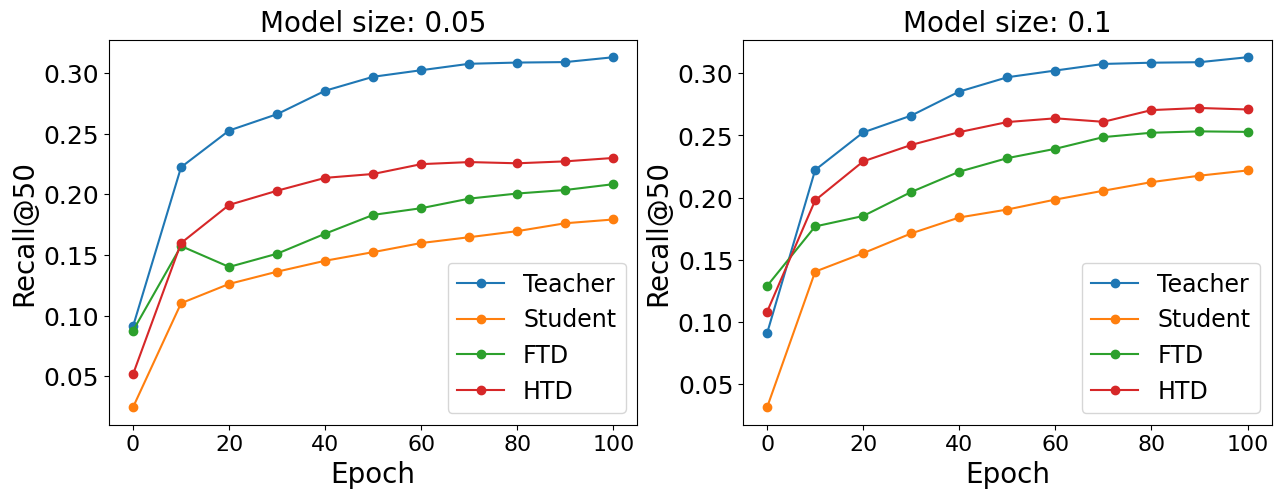

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for idx, student_dim in enumerate([10, 20]):

    axes[idx].plot([i for i in range(0, 101, 10)], Teacher_history, label='Teacher',  marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][0], label='Student', marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][1], label='FTD', marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][2], label='HTD', marker='o')

    axes[idx].legend(loc=4, fontsize=17)
    axes[idx].tick_params(axis="x", labelsize=15.9)
    axes[idx].tick_params(axis="y", labelsize=18)
    axes[idx].set_title('Model size: ' + str(student_dim / 200), fontsize=20)
    axes[idx].set_xlabel('Epoch', fontsize=20)
    axes[idx].set_ylabel('Recall@50', fontsize=20)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for idx, student_dim in enumerate([100, 200]):

    axes[idx].plot([i for i in range(0, 101, 10)], Teacher_history, label='Teacher',  marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][0], label='Student', marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][1], label='FTD', marker='o')
    axes[idx].plot([i for i in range(0, 101, 10)], history_dict[student_dim][2], label='HTD', marker='o')

    axes[idx].legend(loc=4, fontsize=17)
    axes[idx].tick_params(axis="x", labelsize=15.9)
    axes[idx].tick_params(axis="y", labelsize=18)
    axes[idx].set_title('Model size: ' + str(student_dim / 200), fontsize=20)
    axes[idx].set_xlabel('Epoch', fontsize=20)
    axes[idx].set_ylabel('Recall@50', fontsize=20)

NameError: ignored

In [ ]:
files.download('/content/FTD_100.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/FTD_200.pkl')
files.download('/content/FTD_20.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/HTD_100.pkl')
files.download('/content/HTD_20.pkl')
files.download('/content/HTD_10.pkl')
files.download('/content/HTD_200.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/Teacher.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Neumf

In [ ]:
class NeuMF(nn.Module):
	def __init__(self, user_count, item_count, dim, num_hidden_layer, gpu):
		"""
		Parameters
		----------
		user_count : int
		item_count : int
		dim : int
			embedding dimension
		num_hidden_layer : int
			num. of hidden layers in MLP
		gpu : if available
		"""
		super(NeuMF, self).__init__()

		self.user_count = user_count
		self.item_count = item_count

		self.user_list = torch.LongTensor([i for i in range(user_count)])
		self.item_list = torch.LongTensor([i for i in range(item_count)])

		if gpu != None:
			self.user_list = self.user_list.to(gpu)
			self.item_list = self.item_list.to(gpu)


		# User / Item Embedding
		self.user_emb_MF = nn.Embedding(self.user_count, dim)
		self.item_emb_MF = nn.Embedding(self.item_count, dim)

		self.user_emb_MLP = nn.Embedding(self.user_count, dim)
		self.item_emb_MLP = nn.Embedding(self.item_count, dim)

		self.sim_type = 'network'

		nn.init.normal_(self.user_emb_MF.weight, mean=0., std= 0.01)
		nn.init.normal_(self.item_emb_MF.weight, mean=0., std= 0.01)

		nn.init.normal_(self.user_emb_MLP.weight, mean=0., std= 0.01)
		nn.init.normal_(self.item_emb_MLP.weight, mean=0., std= 0.01)

		# Layer configuration
		##  MLP Layers
		MLP_layers = []
		layers_shape = [dim * 2]
		for i in range(num_hidden_layer):
			layers_shape.append(layers_shape[-1] // 2)
			MLP_layers.append(nn.Linear(layers_shape[-2], layers_shape[-1]))
			MLP_layers.append(nn.ReLU())

		print("MLP Layer Shape ::", layers_shape)
		self.MLP_layers = nn.Sequential(* MLP_layers)

		## Final Layer
		self.final_layer  = nn.Linear(layers_shape[-1] * 2, 1)

		self._init_weights()

		# Loss function
		self.BCE_loss = nn.BCEWithLogitsLoss(reduction='sum')


	def _init_weights(self):
		# Layer initialization
		for m in self.MLP_layers:
			if isinstance(m, nn.Linear):
				nn.init.xavier_uniform_(m.weight)
		nn.init.kaiming_uniform_(self.final_layer.weight, a=1, nonlinearity='relu')

		for m in self.modules():
			if isinstance(m, nn.Linear) and m.bias is not None:
				m.bias.data.zero_()


	def forward(self, batch_user, batch_pos_item, batch_neg_item):
		"""
		Parameters
		----------
		batch_user : 1-D LongTensor (batch_size)
		batch_pos_item : 1-D LongTensor (batch_size)
		batch_neg_item : 1-D LongTensor (batch_size)

		Returns
		-------
		output :
			Model output to calculate its loss function
		"""

		pos_score = self.forward_no_neg(batch_user, batch_pos_item)	 # bs x 1
		neg_score = self.forward_no_neg(batch_user, batch_neg_item)	 # bs x 1

		output = (pos_score, neg_score)

		return output


	def forward_no_neg(self, batch_user, batch_item):
		"""forward without negative items

		Parameters
		----------
		batch_user : 1-D LongTensor (batch_size)
		batch_item : 1-D LongTensor (batch_size)

		Returns
		-------
		output : 2-D LongTensor (batch_size x 1)
		"""

		# MF
		u_mf = self.user_emb_MF(batch_user)			# batch_size x dim
		i_mf = self.item_emb_MF(batch_item)			# batch_size x dim

		mf_vector = (u_mf * i_mf)					# batch_size x dim

		# MLP
		u_mlp = self.user_emb_MLP(batch_user)		# batch_size x dim
		i_mlp = self.item_emb_MLP(batch_item)		# batch_size x dim

		mlp_vector = torch.cat([u_mlp, i_mlp], dim=-1)
		mlp_vector = self.MLP_layers(mlp_vector)

		predict_vector = torch.cat([mf_vector, mlp_vector], dim=-1)
		output = self.final_layer(predict_vector)

		return output

In [ ]:
def run_neumf(run_dict, model, file=""):
    optimizer = Adam(model.parameters(), lr=run_dict['lr'], weight_decay=run_dict['reg'])
    train_loader, test_dataset = run_dict['train_loader'], run_dict['test_dataset']
    gpu = run_dict['gpu']
    early_stop = 0.
    history = []

    # Begin training
    for epoch in range(run_dict['max_epoch'] + 1):
        train_loader.dataset.negative_sampling()
        epoch_loss = []

        for batch_user, batch_pos_item, batch_neg_item in train_loader:
            batch_user = batch_user.to(gpu)
            batch_pos_item = batch_pos_item.to(gpu)
            batch_neg_item = batch_neg_item.to(gpu)

            model.train()

            # Base Model
            output = model(batch_user, batch_pos_item, batch_neg_item)
            base_loss = model.get_loss(output)
            batch_loss = base_loss
            epoch_loss.append(batch_loss)

            # Backward and optimize
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        epoch_loss = float(torch.mean(torch.stack(epoch_loss)))

        # Evaluation
        if epoch % run_dict['eval_period'] == 0:
            model.eval()
            with torch.no_grad():
                eval_results = evaluate(model, gpu, train_loader, test_dataset)
                current_R50 = eval_results['test']['R50']

            history.append(current_R50)
            clear_output()
            display('Epoch [%d/%d], Recall@50: %.4f' % (epoch, run_dict['max_epoch'], current_R50))

    clear_output()
    print("Train Done!, Recall@50: %.4f" % (current_R50))

    if file:
        save_to_pickle(model, file)

    return history

In [ ]:
Teacher = NeuMF(user_num, item_num, dim=200, num_hidden_layer=3, gpu=gpu).to(gpu)
Teacher_history = run_base(run_dict, Teacher,filept)